In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tqdm
from scipy.linalg import solveh_banded
from itertools import product
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class FEM_2D():
    """Class to calculate the area minimizing surface 
    of a soap film on a fixed wire frame."""
    
    def __init__(self, 
                 N         = 10,
                 BC_bottom = lambda x: 0,
                 BC_top    = lambda x: 0,
                 BC_left   = lambda y: np.sin(np.pi*y),
                 BC_right  = lambda y: np.sin(np.pi*y),
                 u_start   = lambda x,y: np.sin(np.pi*y)):
        
        # The number of gridpoints in both (x,y) directions
        self.N          = N
        
        # The boundary conditions at the 4 edges of the unit square
        self.BC_bottom  = np.vectorize(BC_bottom)
        self.BC_top     = np.vectorize(BC_top)
        self.BC_left    = np.vectorize(BC_left)
        self.BC_right   = np.vectorize(BC_right)
        self.u_start    = np.vectorize(u_start)
        
        # The various fixed numbers in the computations
        self.n_elements          = 2*(N-1)**2
        self.n_vertices          = N**2
        self.n_boundary_vertices = 4*N-4
        self.n_interior_vertices = (N-2)**2
        
        # Initiation of the linear system Su = f
        self.u = np.zeros((self.n_vertices))
        self.f = np.zeros((self.n_interior_vertices,))
        self.S = np.zeros((self.n_interior_vertices,
                           self.n_interior_vertices))
        
        
        
    def FemSolve2D(self,
                   P_iters        = 5,
                   compute_errors = False):
        """Execute the entire FEM calculation."""
        
        errors = []
        
        self.GenerateMesh()
        self.GenerateTopology()
        self.GenerateElementProperties()
        self.SetPicardStart()
        
        for i in tqdm.tqdm(range(P_iters), desc = "Picard iterations"):
            
            self.AssembleMatrix()
            self.AssembleVector()
            
            error = self.SolveLinearSystem(compute_error = compute_errors)
            
            errors.append(error)
            
        return errors
    
    
    
    def SolveLinearSystem(self, compute_error = False):
        """Solve the linear system resulting from FEM and compute the L2 error."""
        
        u_old                             = np.copy(self.u)          
        self.u[:self.n_interior_vertices] = solveh_banded(self.CondenseMatrix(),
                                                          self.f, overwrite_ab = True)
        
        u_diff   = self.u - u_old
        error_sq = 0
        
        if compute_error:

            for l in range(self.n_elements):
                abs_element_determinant = abs(self.element_determinants[l])

                for labda, mu in product(range(3), repeat = 2):

                    if labda == mu:
                        error_sq += u_diff[self.elmat[l,mu]]**2 * abs_element_determinant/30

                    else:
                        error_sq += np.prod(u_diff[self.elmat[l,(labda,mu)]]) * abs_element_determinant/180

            return np.sqrt(error_sq)
        
        else:   
            return 0
            
        
        
    def GenerateMesh(self):
        """Generate the FEM mesh and order the vertices such that the interior vertices come first."""
        
        # An array of the vertex coordinates in lexicographical ordering
        x_coordinates  = np.linspace(0,1,self.N)
        y_coordinates  = np.linspace(0,1,self.N)
        x_grid, y_grid = np.meshgrid(x_coordinates,y_coordinates)
        x              = np.stack([x_grid.flat,y_grid.flat])
        
        # Permutation of grid-node indices so that the interior nodes come first
        boundary_bool = np.zeros((self.N, self.N), dtype = bool)
        boundary_bool[(0,self.N-1),:] = True
        boundary_bool[:,(0,self.N-1)] = True
        is_boundary                   = np.array(boundary_bool.flat)
        unpermuted_vertex_indices     = np.arange(self.N**2)
        permuted_vertex_indices       = np.concatenate([unpermuted_vertex_indices[~is_boundary],
                                                        unpermuted_vertex_indices[is_boundary]])
        self.vertex_permutation       = np.argsort(permuted_vertex_indices)
        
        # Permute x
        self.x = x[:,permuted_vertex_indices] 
        
        
        
    def GenerateTopology(self):
        """Generate the FEM topology."""
        
        elmat = np.zeros((self.n_elements,3), dtype = int)
        
        touches_boundary = np.zeros((self.n_elements,), dtype = bool)
        
        for n_x, n_y in product(range(self.N-1), repeat = 2):
            # Every (n_x, n_y) is the lower left corner of a square which contains 2 elements, 'lower left' one 
            # and an 'upper right' one.
            
            # Bottom left gridnode index before permutation
            bottom_left_index = self.N*n_y + n_x  
            
            # Lower left element
            LL_element_index        = 2*((self.N-1)*n_y + n_x)
            elmat[LL_element_index] = self.vertex_permutation[[bottom_left_index, 
                                                               bottom_left_index + 1, 
                                                               bottom_left_index + self.N]]
            
            # Upper right element
            UR_element_index        = LL_element_index + 1
            elmat[UR_element_index] = self.vertex_permutation[[bottom_left_index + 1, 
                                                               bottom_left_index + self.N + 1, 
                                                               bottom_left_index + self.N]]
            
            # Check whether elements touch the boundary
            if not np.all(elmat[LL_element_index] < self.n_interior_vertices):
                touches_boundary[LL_element_index] = True
                
            if not np.all(elmat[UR_element_index] < self.n_interior_vertices):
                touches_boundary[UR_element_index] = True
                
        self.elmat            = elmat
        self.touches_boundary = touches_boundary

        # Triangulation object for 3D plotting
        self.Tri = tri.Triangulation(self.x[0],self.x[1], triangles = self.elmat)
        
        
        
    def GenerateElementProperties(self):
        """Calculate coefficients of the linear basis functions in the elements,
        and the determinant of the vertex matrix of each element."""
        
        vertex_matrices      = np.ones((self.n_elements,3,3))
        element_determinants = np.zeros((self.n_elements,)) 
        
        for l in range(self.n_elements):
            vertex_matrices[l,:,1:] = self.x[:,self.elmat[l]].T
            
        self.coefficient_matrices = np.linalg.inv(vertex_matrices)
        self.element_determinants = np.linalg.det(vertex_matrices)
            
            
    
    def ComputeBoundary(self):
        """Compute the values of the approximation of u at the boundary vertices, based on the boundary conditions.
        These are constant over the Picard iterations."""
        
        u_boundary  = np.zeros((self.n_boundary_vertices,))
        u_bottom    = self.BC_bottom(np.linspace(0,1,self.N))
        u_top       = self.BC_top(np.linspace(0,1,self.N))
        u_left      = self.BC_left(np.linspace(0,1,self.N))
        u_right     = self.BC_right(np.linspace(0,1,self.N))
        u_leftright = np.array(np.stack([u_left,u_right]).T.flat)
        
        u_boundary[:self.N]             = u_bottom
        u_boundary[self.N-2:3*self.N-2] = u_leftright
        u_boundary[-self.N:]            = u_top
        
        return u_boundary
        
        
        
    def SetPicardStart(self):
        """Set the initial solution u0 for the Picard iteration. The values for the interior vertices are computed with 
        the provided function u_start, the values for the boundary vertices are computed with the provided boundary 
        conditions."""
        
        interior_vertices_start = self.u_start(self.x[0, :self.n_interior_vertices],
                                               self.x[1, :self.n_interior_vertices])
        
        self.u[:self.n_interior_vertices] = interior_vertices_start
        self.u[self.n_interior_vertices:] = self.ComputeBoundary()
        
        
        
    def GenerateElementMatrix(self,l):
        """Generate the element matrix."""
        
        # Get coefficients of the linear basis functions
        S_elem              = np.zeros((3,3))
        coef_matrix         = self.coefficient_matrices[l]
        
        # Compute denominator of the S_elem expression
        grad_utilde_k      = np.sum([self.u[j]*coef_matrix[1:,mu] 
                                    for mu,j in enumerate(self.elmat[l])],
                                    axis = 0)
        denominator        = np.sqrt(1 + np.inner(grad_utilde_k,grad_utilde_k))
        element_area       = abs(self.element_determinants[l])/2
        
        for labda, mu in product(range(3), repeat = 2):
            
            S_elem[labda, mu] = np.inner(coef_matrix[1:,labda],coef_matrix[1:,mu])
            
        return element_area*S_elem/denominator
    
        
        
    def AssembleMatrix(self):
        """Assemble the matrix S for the linear system Su = f."""
        
        S = np.zeros((self.n_interior_vertices,
                      self.n_interior_vertices))
        
        for l in range(self.n_elements):
            
            S_elem = self.GenerateElementMatrix(l)
            
            for labda,mu in product(range(3), repeat = 2):
                
                # Check whether the indices refer to an interior node
                # (and thus an unknown)
                if self.elmat[l,labda] >= self.n_interior_vertices or self.elmat[l,mu] >= self.n_interior_vertices:
                    continue
            
                S[self.elmat[l,labda],self.elmat[l,mu]] += S_elem[labda,mu]
                
        self.S = S
        
        
        
    def CondenseMatrix(self):
        """Make use of the symmetric positive definite band structure of the matrix S to condense it in
        upper diagonal ordered form, see
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solveh_banded.html."""
        
        S_condensed = np.zeros((self.N-1,self.n_interior_vertices))
        
        for i in range(self.n_interior_vertices):
            
            i_slice = self.S[max(0, i - (self.N - 2)):i+1, i]
            
            S_condensed[-len(i_slice):, i] = i_slice
                
        return S_condensed
            
        
        
    def GenerateElementVector(self,l):
        """Generate the element vector."""
        
        if self.touches_boundary[l]:
            
            # Compute coefficients of the linear basis functions
            f_belem             = np.zeros((3,))
            coef_matrix         = self.coefficient_matrices[l]

            # Compute denominator of the f_belem expression
            grad_utilde_k = np.sum([self.u[j]*coef_matrix[1:,mu] 
                                    for mu,j in enumerate(self.elmat[l])],
                                    axis = 0)
            denominator   = np.sqrt(1 + np.inner(grad_utilde_k,grad_utilde_k))
            element_area  = abs(self.element_determinants[l])/2
            
            for labda in range(3):
                
                if self.elmat[l,labda] < self.n_interior_vertices:
                    
                    Sum = np.sum([self.u[j]*coef_matrix[1:,mu] 
                                  for mu,j in enumerate(self.elmat[l]) if not j < self.n_interior_vertices],
                                  axis = 0)
                    
                    f_belem[labda] = np.inner(coef_matrix[1:,labda],Sum)
            
            return -element_area*f_belem/denominator
            
        else:
            
            return np.zeros((3,))
        
        
        
    def AssembleVector(self):
        """Assemble the vector f for the linear system Su = f."""
        
        f = np.zeros((self.n_interior_vertices,))
        
        for l in range(self.n_elements):
            
            f_elem = self.GenerateElementVector(l)
            
            for labda in range(3):
                
                # Check whether the index refers to a boundary vertex
                # and thus a known
                if not self.elmat[l,labda] < self.n_interior_vertices:
                    continue
                
                f[self.elmat[l,labda]] += f_elem[labda]
        
        self.f = f
        
        
        
    def plot(self, cmap = 'ocean', save_as = '', n_levels = 10):
        """Plot 3D and contour plots of the solution u."""
        
        fig     = plt.figure(figsize = (10,5))
        ax_3D   = fig.add_subplot(121, projection='3d')
        ax_cont = fig.add_subplot(122)
        
        ax_3D.view_init(azim=-124)
        ax_3D.plot_trisurf(self.x[0], self.x[1], self.u, triangles = self.Tri.triangles, cmap = cmap)
        ax_3D.set_xlabel('$x$')
        ax_3D.set_ylabel('$y$')
        
        cont_im = ax_cont.tricontourf(self.Tri, self.u,
                            levels = np.linspace(np.min(self.u),np.max(self.u), n_levels),
                            cmap   = cmap)
        
        ax_cont.tricontour(self.Tri, self.u,
                    levels = np.linspace(np.min(self.u),np.max(self.u), n_levels),
                    colors = 'k')
        
        ax_cont.set_xlabel('$x$')
        ax_cont.set_ylabel('$y$')
        ax_cont.set_aspect('equal')
        
        divider = make_axes_locatable(ax_cont)
        cax     = divider.append_axes('right', size='5%', pad=0.05)
        cbar    = plt.colorbar(cont_im, cax = cax)
        
        if len(save_as) > 0:
            plt.savefig(save_as)
        
        plt.show()

## Test ordering

In [3]:
F_ordertest = FEM_2D(N = 5)
F_ordertest.GenerateMesh()
print(np.flipud(F_ordertest.vertex_permutation.reshape(F_ordertest.N,F_ordertest.N)))

[[20 21 22 23 24]
 [18  6  7  8 19]
 [16  3  4  5 17]
 [14  0  1  2 15]
 [ 9 10 11 12 13]]


## Test Topology

<IPython.core.display.Javascript object>


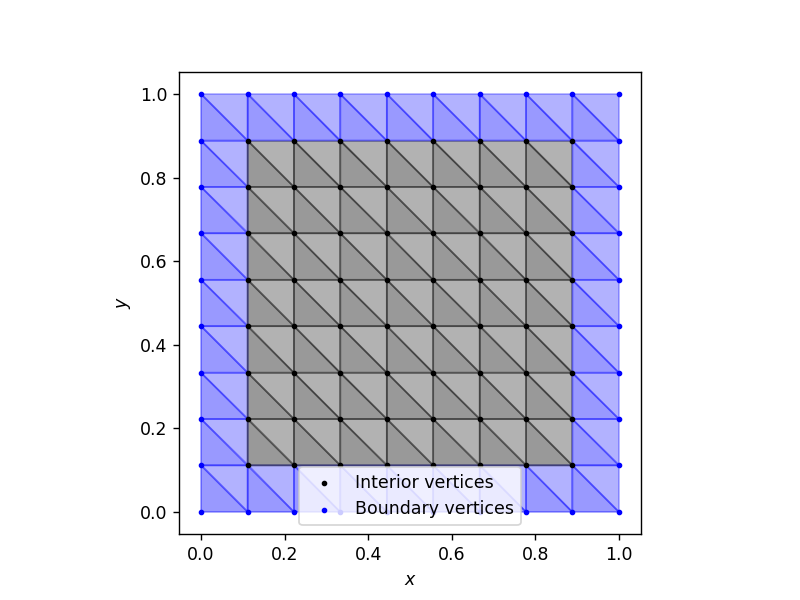

In [4]:
# Make 3 categories of grid-vertices (with Boolean arrays): boundary, interior, and interior adjacent to boundary
# Plot with different colors

F_topotest = FEM_2D()
F_topotest.GenerateMesh()
F_topotest.GenerateTopology()

fig, ax = plt.subplots()

ax.scatter(F_topotest.x[0,:F_topotest.n_interior_vertices], 
           F_topotest.x[1,:F_topotest.n_interior_vertices], s = 5, color = 'k', 
           label = 'Interior vertices')
ax.scatter(F_topotest.x[0,F_topotest.n_interior_vertices:], 
           F_topotest.x[1,F_topotest.n_interior_vertices:], s = 5, color = 'b', 
           label = 'Boundary vertices')

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()

for i in range(F_topotest.n_elements):
    
    if F_topotest.touches_boundary[i]:
        color = 'b'
    else:
        color = 'k'
    
    if i % 2 == 0:
        alpha = 0.4
    else:
        alpha = 0.3
        
    element = Polygon(F_topotest.x[:,F_topotest.elmat[i]].T, alpha = alpha, color = color, zorder = 0, label = 'yeet')

    ax.add_patch(element)

plt.savefig('mesh.png')

## Test 3D plotting

In [5]:
F_plottest = FEM_2D(N = 100)
F_plottest.GenerateMesh()
F_plottest.GenerateTopology()
F_plottest.SetPicardStart()

<IPython.core.display.Javascript object>


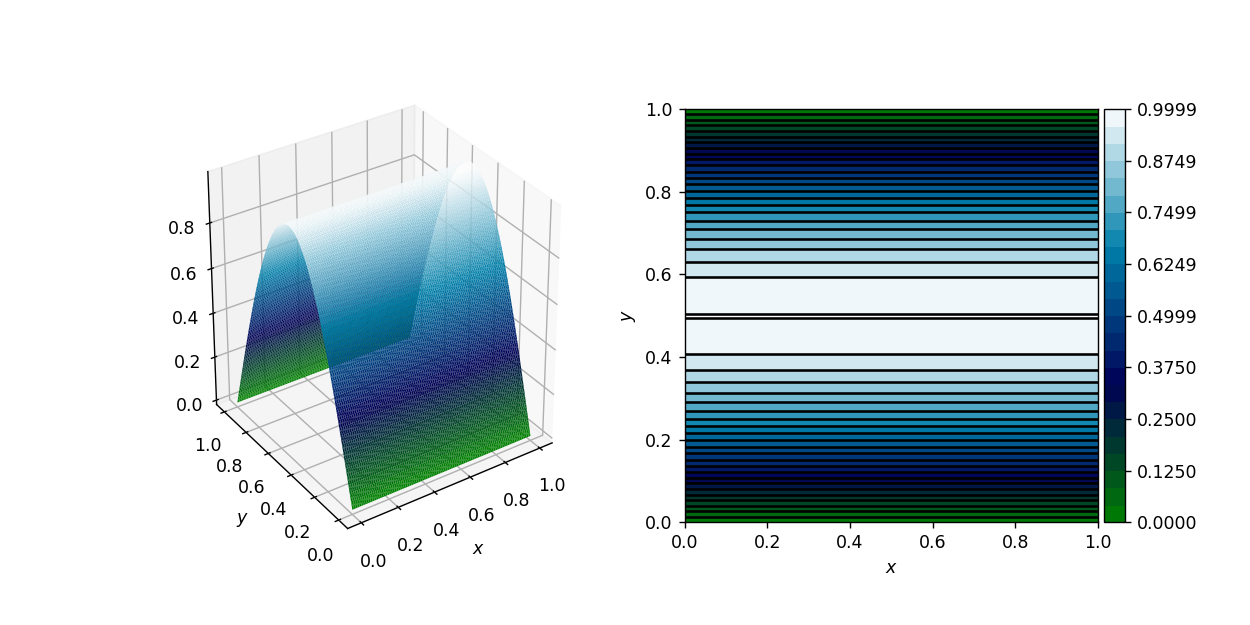

In [6]:
F_plottest.plot(save_as = 'Picard_start.png', n_levels = 25)

## Test matrix $S$ and vector $\mathbf{f}$ construction, and $S$ condensation

<IPython.core.display.Javascript object>


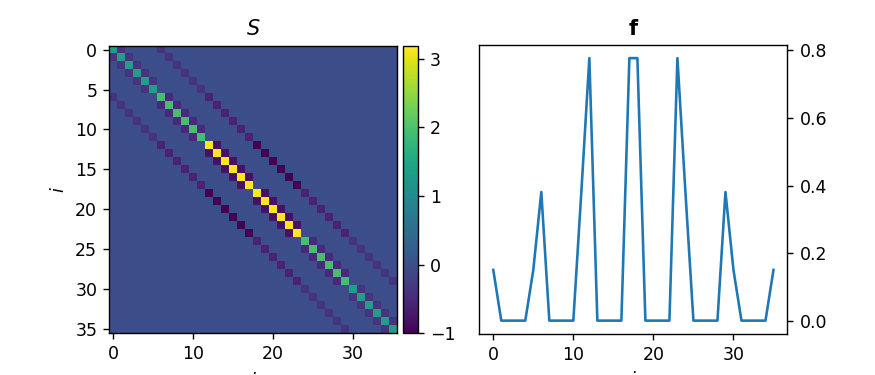

<IPython.core.display.Javascript object>


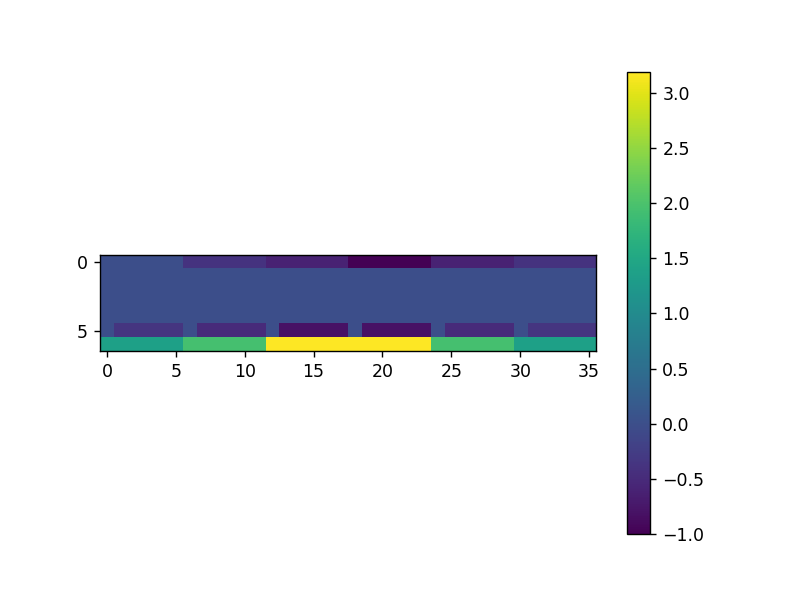

In [7]:
fig, axs = plt.subplots(1,2, figsize = (7,3))

F_linsystest = FEM_2D(N = 8)
F_linsystest.GenerateMesh()
F_linsystest.GenerateTopology()
F_linsystest.GenerateElementProperties()
F_linsystest.SetPicardStart()
F_linsystest.AssembleMatrix()
F_linsystest.AssembleVector()
S_condensed = F_linsystest.CondenseMatrix()

S_im = axs[0].imshow(F_linsystest.S)
axs[0].set_ylabel('$i$')
axs[0].set_xlabel('$j$')
axs[0].set_title('$S$')

divider = make_axes_locatable(axs[0])
cax     = divider.append_axes('right', size='5%', pad=0.05)
cbar    = plt.colorbar(S_im, cax = cax)

axs[1].plot(F_linsystest.f)
axs[1].set_title('$\mathbf{f}$')
axs[1].set_xlabel('$i$')
axs[1].yaxis.tick_right()

plt.savefig("Sandf.png")

fig, ax = plt.subplots()
im = ax.imshow(S_condensed)
fig.colorbar(im)
plt.show()

## Test Picard Iteration and error

In [8]:
F_itertest = FEM_2D(N = 100)
P_iters    = 25
errors     = F_itertest.FemSolve2D(P_iters = P_iters, compute_errors = True)

Picard iterations: 100%|███████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.36s/it]


<IPython.core.display.Javascript object>


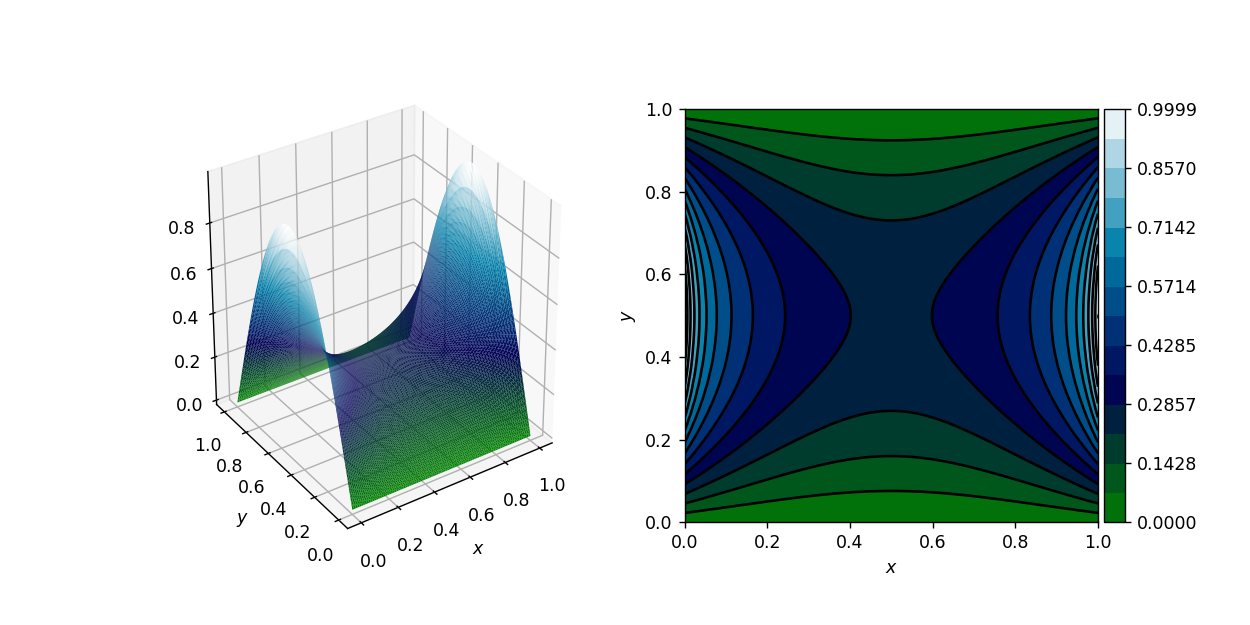

<IPython.core.display.Javascript object>


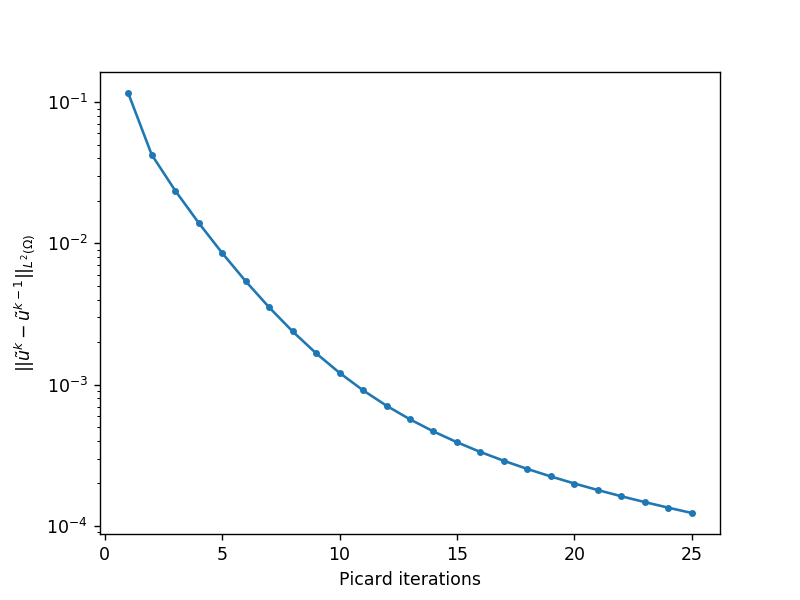

In [9]:
F_itertest.plot(save_as = 'Saddle_solution.png', n_levels = 15)

fig, ax = plt.subplots()
ax.plot(range(1,P_iters+1),errors, marker = '.')
ax.set_yscale('log')
ax.set_xlabel('Picard iterations')
ax.set_ylabel('$||\\tilde{u}^k-\\tilde{u}^{k-1}||_{L^2(\Omega)}$');

plt.savefig('PicardErrors.png')

## Something fancy

In [10]:
f1 = lambda x : np.where(x<1/2, 
                          np.sqrt(np.maximum(0,1/16 - (x-1/4)**2)),
                         -np.sqrt(np.maximum(0,1/16 - (x-3/4)**2)))
f2 = lambda x : np.where(x<1/2, 
                         -np.sqrt(np.maximum(0,1/16 - (x-1/4)**2)),
                          np.sqrt(np.maximum(0,1/16 - (x-3/4)**2)))

F_fancy = FEM_2D(N         = 100,
                 BC_left   = f1,
                 BC_right  = f2,
                 BC_top    = f1,
                 BC_bottom = f2,
                 u_start   = lambda x,y: 0)

F_fancy.FemSolve2D(P_iters = 10);

Picard iterations: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


<IPython.core.display.Javascript object>


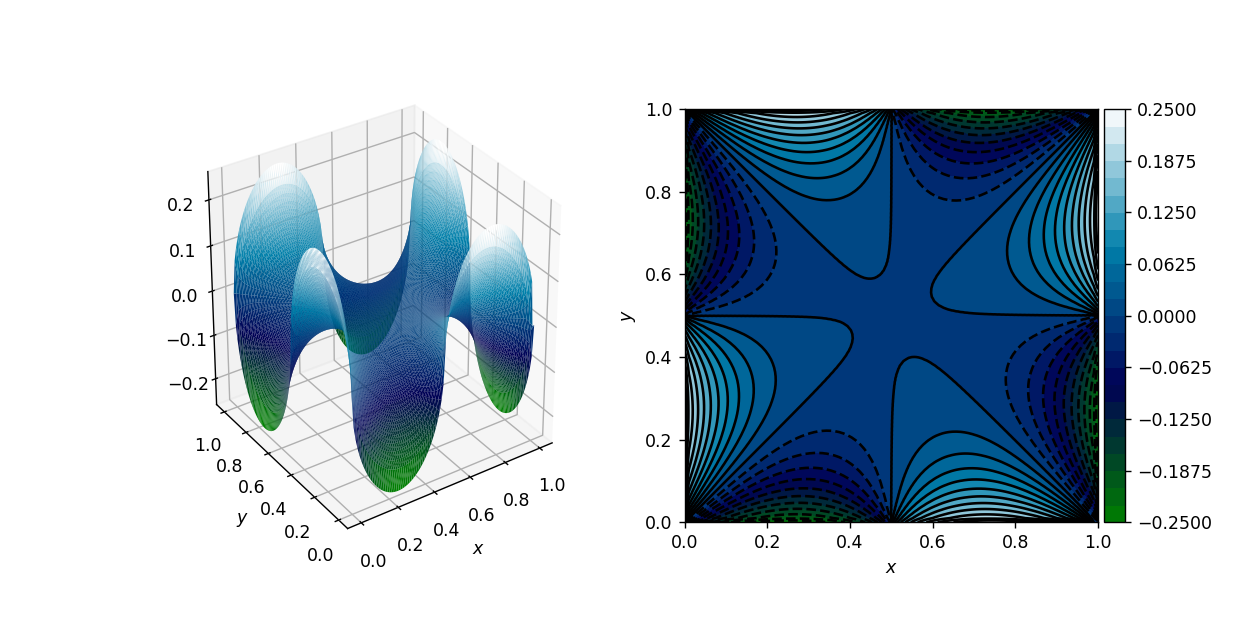

In [11]:
F_fancy.plot(save_as = 'Something_fancy.png', n_levels = 25)